# Model Description

For $n=1,...,N$,
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Z_n \sim N(0,\tau^2)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t})}\right)$
<br>
for $t=1, ..., T$. This model carries out dimentionality reduction of binary observations $y_{n,k}$'s. Here, the dimention of $\beta$ and $x_{n,t}$ is $D$.<br>
As variational approximation of the posterior $p(z_n|y_n)$, we use $q(z_n)= N(z_n;\mu_n, \sigma_n^2)$

#### We do not consider the use of Renyi divergences

# Import Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
from matplotlib import pyplot as plt

# Utilities

In [3]:
tf_float_type = tf.float64
np_float_type = np.float64
as_tf_float = lambda x: tf.cast(x, tf_float_type)

In [4]:
def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

In [5]:
sigmoid = lambda x:1/(1+np.exp(-x))

# Generate Toy Dataset

In [6]:
N = 1000
D = 3
T = 2

In [7]:
# data
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, T, beta0, beta, ln_tau):
    z = np.random.randn(N) * np.exp(ln_tau)
    x = np.random.randn(N*T*D).reshape([N,T,D])
    y = bernoulli(p=sigmoid(beta0+x@beta+z.reshape([N,1]))).rvs()
    return x,y,z

In [8]:
# paramters
ln_tau = np.float64(0.7)
beta0 = np.float64(0.)
beta  = np.random.randn(D) / np.sqrt(D)
param0 = {
    'ln_tau': ln_tau,
    'beta0': float(beta0),
    'beta': beta
}

In [9]:
x,y,z = generate_data(N, D, T, beta0, beta, ln_tau)

## Sigmoid Normal Integral Approximation of Evidence

Ref: Barber Bishop(1998), PRML(2006)

In [10]:
def sigmoid_normal_prob(x, beta0, beta, ln_tau):
    N, T, D  = x.shape
    kappa = 1 / (1 + np.pi*tf.exp(ln_tau*2)/8)**(1/2)
    return tf.math.sigmoid( kappa * (beta0 + tf.reshape( x@tf.reshape(beta, [D,1]), [N, T])) )

In [11]:
def sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau):
    pred_prob = sigmoid_normal_prob(x, beta0, beta, ln_tau)
    score = tf.reduce_mean(tf.reduce_sum(
        tf.math.log(pred_prob)*y + tf.math.log(1-pred_prob)*(1-y), 
        axis=1))
    return score

## Laplace Approximation of Posterior

In [12]:
def laplace_approx(x, y, beta0, beta, ln_tau):
    N, T, D  = x.shape
    z = np.zeros([N, 1])
    _sig = lambda z: sigmoid( z + beta0 + x@beta )
    for i in range(10):
        sig = _sig(z)
        hessian = 1/np.exp(ln_tau*2) + np.sum( sig*(1-sig), axis=1, keepdims=True)
        grad    = z/np.exp(ln_tau*2) + np.sum( sig - y,     axis=1, keepdims=True)
        z -= grad / hessian
    mu = z.reshape([N])
    sigma = (1 / hessian).reshape([N])**(1/2)
    return mu, sigma

In [13]:
mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)

In [14]:
z.var(), (z-mu).var()

(3.7493583685054985, 1.8282650456550973)

# IWELBO approximation of Evidence

In [15]:
def pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma):
    """
    Compute IWELBOs for i = 1,...,n using n_MC samples Zn. 
    Here, we assume that n<N where N is the size of data.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    beta: 1-d array of size [D]
    mu: 1-d array of [N]
    sigma**2: 1-d array of [N]
    
    Returns:
    iwelbo: iwelbo, whose size is [N]
    """

    (N, T, D), (n_MC, n) = x.shape, z.shape
    y = np.float64( y.reshape([1,N,T]) )
    mu = mu.reshape([1,N])
    sigma = sigma.reshape([1,N])
    
    y_logits = tf.convert_to_tensor( beta0\
                                    + tf.reshape( x@tf.reshape(beta, [D,1]), [1, N, T])\
                                    + tf.reshape(z, [n_MC, N, 1]) 
                                   )
    p_y = tfp.distributions.Bernoulli(logits=y_logits)
    p_z = tfp.distributions.Normal(loc=np.zeros([1, N]), scale=tf.exp(ln_tau))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    iwelbo = tf_logmeanexp(log_prob_ratio, axis=0)
    return iwelbo

In [16]:
def IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC):
    N, = mu.shape
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    iwelbo = tf.reduce_mean( pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma) )
    return iwelbo

In [17]:
signorm_likelihood = sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau).numpy()
elbo_likelihood = IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1).numpy()
iwelbo_likelihood = IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64).numpy()

In [18]:
signorm_likelihood, elbo_likelihood, iwelbo_likelihood

(-1.3203896752599162, -1.2723016180869178, -1.253648532390383)

## Maximum Likelihood by Different Approximation

In [19]:
# Orthogonalize the covariate with z

In [20]:
objectives = {
    "signorm": lambda beta0, beta, ln_tau, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau),
    "elbo": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1),
    "iwelbo": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64)
}
params = {"ground_truth": param0}

N,T,D = 1000, 2, 3

for obj_name, obj_func in objectives.items():
    
    print("training {}...".format(obj_name))
    
    beta0_ = tf.Variable(0, dtype=tf.float64)
    beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
    ln_tau_   = tf.Variable(0, dtype=tf.float64)

    for t in range(501):
        
        rho_t = 0.4/(1+t)**0.6
        x,y,z = generate_data(N, D, T, beta0, beta, ln_tau)

        with tf.GradientTape() as g:
            g.watch([beta0_, beta_, ln_tau_])
            mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), ln_tau_.numpy())
            score = obj_func(beta0_, beta_, ln_tau_, mu, sigma)
        dbeta0_, dbeta_, dln_tau_ = g.gradient(score, [beta0_, beta_, ln_tau_])

        beta0_ = beta0_ + rho_t*dbeta0_
        beta_ = beta_ + rho_t*dbeta_
        ln_tau_ = ln_tau_ + dln_tau_
        if t%50==0:
            print("#iter: {},\tloss: {}".format(t, -score.numpy()))
    
    params[obj_name] = {
        'ln_tau': ln_tau_.numpy(),
        'beta0': beta0_.numpy(),
        'beta': beta_.numpy()
    }
    print()

training signorm...
#iter: 0,	loss: 1.3862943611198932
#iter: 50,	loss: 1.3151852548766374
#iter: 100,	loss: 1.3137125645426742
#iter: 150,	loss: 1.324545748930499
#iter: 200,	loss: 1.3141075942885732
#iter: 250,	loss: 1.315122492975311
#iter: 300,	loss: 1.3310153518960433
#iter: 350,	loss: 1.345113408896049
#iter: 400,	loss: 1.3194260500563697
#iter: 450,	loss: 1.3225143219234416
#iter: 500,	loss: 1.3236479859736694

training elbo...
#iter: 0,	loss: 1.3415605333790197
#iter: 50,	loss: 1.2731602254332437
#iter: 100,	loss: 1.285275571297805
#iter: 150,	loss: 1.2788582109802928
#iter: 200,	loss: 1.2661287597939659
#iter: 250,	loss: 1.2706540211617823
#iter: 300,	loss: 1.2801926866140747
#iter: 350,	loss: 1.2943098665864323
#iter: 400,	loss: 1.2885737504799528
#iter: 450,	loss: 1.2848891639091862
#iter: 500,	loss: 1.279308153718729

training iwelbo...
#iter: 0,	loss: 1.3360464222864787
#iter: 50,	loss: 1.274962587998346
#iter: 100,	loss: 1.2680590053145462
#iter: 150,	loss: 1.252387791500

In [21]:
params

{'ground_truth': {'ln_tau': 0.7,
  'beta0': 0.0,
  'beta': array([ 0.75288457, -0.37000288, -0.09201359])},
 'signorm': {'ln_tau': -0.5859231970542182,
  'beta0': -0.0023429182295627475,
  'beta': array([ 0.48663008, -0.23394813, -0.05818374])},
 'elbo': {'ln_tau': -0.09090616029911061,
  'beta0': 0.0013032877725931912,
  'beta': array([ 0.54273325, -0.26712958, -0.06530728])},
 'iwelbo': {'ln_tau': 0.598227501316516,
  'beta0': 0.0017900352768665106,
  'beta': array([ 0.64130361, -0.318238  , -0.07404593])}}

Bottom Line: IWELBO gives better estiamte than elbo or sigmoid normal integral approximation. 

# MLMC codition check

In [22]:
def pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma):
    
    (N, T, D), (n_MC, N) = x.shape, z.shape
    assert np.log2(n_MC)%1==0
    
    if n_MC == 1:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma)
    else:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[:n_MC//2 ], beta0, beta, ln_tau, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[ n_MC//2:], beta0, beta, ln_tau, mu, sigma)
    return scores

In [23]:
def dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbo = tf.reduce_mean( pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma) )
    return diwelbo

# MLMC

In [24]:
def IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=8, start_level=0):
    
    N, T, D = x.shape

    levels = np.arange(start_level, max_level+1)
    weights = 2.**(-3/2*levels)
    weights /= sum(weights)
    Ns = np.zeros_like(levels)
    Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
    Ns[0] = N - sum(Ns[1:])
    
    N_offset = 0
    score = 0
    for i, l in enumerate(levels):
        x_tmp = x[N_offset:N_offset+Ns[i]]
        y_tmp = y[N_offset:N_offset+Ns[i]]
        mu_tmp = mu[N_offset:N_offset+Ns[i]]
        sigma_tmp = sigma[N_offset:N_offset+Ns[i]]
        
        score += dIWELBO(x_tmp, y_tmp, beta0, beta, ln_tau, mu_tmp, sigma_tmp, level=l)
        N_offset += Ns[i]
    return score

In [25]:
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=10, start_level=0)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2732106991752004>

## Comparison

In [26]:
def conv_stats_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
    mean_diwelbo = diwelbos.mean()
    mean_abs_diwelbo = np.mean(np.abs(diwelbos))
    var_diwelbo = diwelbos.var()
    
    iwelbos = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
    var_iwelbo = iwelbos.var()
    
    return {'mean_dIWELBO':mean_diwelbo, 
            'mean_abs_dIWELBO':mean_abs_diwelbo, 
            'var_dIWELBO':var_diwelbo, 
            'var_IWELBO':var_iwelbo}

In [27]:
conv_stats = [conv_stats_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=l) for l in range(10)]
conv_stats = pd.DataFrame(conv_stats)

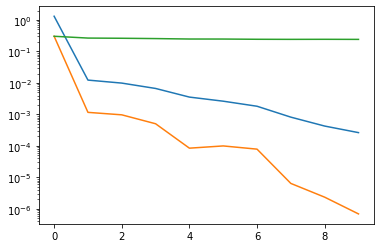

In [28]:
plt.plot(conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO', 'var_IWELBO']])
plt.yscale('log')

In [29]:
conv_stats

,mean_dIWELBO,mean_abs_dIWELBO,var_dIWELBO,var_IWELBO
0,-1.307070,1.317098,3.044348e-01,0.304435
1,0.012357,0.012357,1.167473e-03,0.266922
2,0.009924,0.009924,9.748743e-04,0.263227
3,0.006704,0.006704,5.076918e-04,0.257265
4,0.003567,0.003567,8.514586e-05,0.249079
5,0.002643,0.002643,1.002712e-04,0.248546
6,0.001826,0.001826,7.926358e-05,0.244455
7,0.000823,0.000823,6.459834e-06,0.243008
8,0.000429,0.000429,2.365271e-06,0.243970
9,0.000265,0.000265,6.953756e-07,0.242552


In [30]:
NMC_ests = []
MLMC_ests = []
for i in range(10):
    x,y,z_ = generate_data(N=200000, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    NMC_ests.append( IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=16).numpy() )
    MLMC_ests.append( IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=4, start_level=0).numpy() )

In [31]:
print("std-div of NMC estimator:  ", np.std(NMC_ests))
print("std-div of MLMC estimator: ", np.std(MLMC_ests))

std-div of NMC estimator:   0.0011831697569174653
std-div of MLMC estimator:  0.0017923629487936628


In [32]:
%%timeit
IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64)

1.31 s ± 5.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=6, start_level=0)

133 ms ± 520 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### For finding nice configuration where MLMC wins NMC 

In [34]:
N,_ = y.shape
n_MC = 2
z = norm(loc=mu, scale=sigma).rvs([n_MC, N])

diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
score1 = np.var(NMC_ests) / diwelbos.mean()**2
score2 = np.var(MLMC_ests) / np.var(NMC_ests)
print(score1, score2)

print(np.std(x@beta, axis=1).mean(), z_.std())

0.030590823453341444 2.294868449800949
0.4758576083976454 2.0176034291489637
